# <center>Sheet 3</center>
# <center>Efficient Conjugate Gradient Solver with Preconditioning</center>

### Function `resnorm`
$$[r] = resnorm(A, x\_hat, b)$$
<u>Input</u>: $A$ is a sparse $n \times n$ matrix, $\hat{x}$, $b$ are vectors of size $n$. <br>
<u>Output</u>: scalar $r$, with:
$$r := \frac{||b-A\hat{x}||_1}{||A||_1||\hat{x}||_1}$$ <br>


Remark: Use this function to compute the relative residual norm of the approximate solutions obtained in the Block Jacobi method and in PCG.

In [1]:
def resnorm(A, x_hat, b):
    # check input parameters
    # raise a warning if the 1-norm of x_hat is zero
    if np.linalg.norm(x_hat, ord = 1) == 0:
        warnings.warn("Division by zero in function rel_resnorm. The 1-norm of x_hat is zero.")
        return np.nan
    
    if not sp.sparse.issparse(A):
        raise TypeError("Matrix A must be sparse")
    
    if not all(isinstance(param, np.ndarray) for param in [x_hat, b]):
        raise TypeError("x_hat and b must be numpy arrays")
    
    if A.ndim != 2 and A.shape[0] != A.shape[1]:
        raise ValueError("Matrix A must be square")
    
    if x_hat.ndim != 1 or b.ndim != 1:
        raise ValueError("Vectors x_hat and b must be 1D arrays")
    
    # compute the relative residual norm
    r = np.linalg.norm(A.dot(x_hat) - b, ord = 1) / (sp.sparse.linalg.norm(A, ord = 1) * np.linalg.norm(x_hat, ord = 1))
    return r

# Effects of Preconditioners on the Conjugate Gradient Method
Implement the Block Jacobi method, which is a blocked form of the Jacobi method. The <u>Jacobi method</u> uses the splitting $A = D+E$, where $D$ is a diagonal matrix with the same diagonal entries as $A$. The matrix $E$ contains the off-diagonal values of $A$, its diagonal entries are all zero. The <u>Block Jacobi method</u> corresponds to the splitting $A = D+E$, where $D$ is a block diagonal matrix containing the diagonal blocks of the matrix $A$. We specify that all diagonal blocks are the same size except for potentially the last one.

Experimentally investigate the effect of the Block Jacobi method as a preconditioner on the convergence behaviour of the Preconditioned Conjugate Gradient (PCG) method. Compare PCG for two given test problems in terms of the number of iterations and in terms of the runtime (including the time for computing and applying the preconditioner) until convergence. Show the convergence histories (norm of relative residual vs. iteration number) graphically.

-  Implement the Block Jacobi method and PCG efficiently (you are not allowed to use public implementations available online!). In particular, store the sparse matrix in a <u>sparse matrix format</u>!
- Use the following preconditioners:
    1. Jacobi method with $1$ and $5$ iterations repsectively.
    2. Block Jacobi method (diagonal subblocks of size $5$) with $1$ and $5$ iterations respectively.<br> <br>

- Test matrices: Use the following test matrices from the [Matrix Market](http://math.nist.gov/MatrixMarket/) for your experiments:
    - [NOS5](https://math.nist.gov/MatrixMarket/data/Harwell-Boeing/lanpro/nos5.html)
    - [NOS6](https://math.nist.gov/MatrixMarket/data/Harwell-Boeing/lanpro/nos6.html) <br> <br>

- To import MatrixMarket format (`.mtx`) files into Python and convert them into `numpy` arrays, the following code uses the functions `scipy.io.mmread` and `.toarray()`.
- The returned matrix array holds the matrices in <u>**dense**</u> representation. You must convert them into a <u>**sparse**</u> Scipy format!

In [2]:
# We wrote this to download and decompress the matrices automatically.
import gzip
from os.path import exists
from pathlib import Path
import requests
import scipy as sp
import numpy as np
import warnings

def decompress_gz(source: Path, destination: Path = Path("./"), block_size=65536):
    destination = Path(destination, ".".join(str(source).split(".")[:-1]))
    # check if the file exists
    if exists(destination):
        warnings.warn(f"The file {destination} already exists.")
        return destination
    with gzip.open(source, 'rb') as s_file, open(destination, 'wb') as d_file:
        while True:
            block = s_file.read(block_size)
            if not block:
                break
            else:
                d_file.write(block)
    return destination


def download_and_save(source: Path, destination: Path = Path("./")) -> Path:
    # extract the file name form the url, e.g.: filename.zip form `https:random_website.com/sub_path_0/filename.zip`
    destination = Path(destination, str(source).split("/")[-1])
    # check if the file exists
    if exists(destination):
        warnings.warn(f"The file {destination} already exists.")
        return destination
    # download the content from the url
    r = requests.get(source, allow_redirects=True)
    # write the content in the destination file
    open(destination, 'wb').write(r.content)
    return destination


links = ["https://math.nist.gov/pub/MatrixMarket2/Harwell-Boeing/lanpro/nos5.mtx.gz",
         "https://math.nist.gov/pub/MatrixMarket2/Harwell-Boeing/lanpro/nos6.mtx.gz"]

matrices = [sp.io.mmread(decompress_gz(download_and_save(matrix_url))).toarray() for matrix_url in links]

C:\Users\Merlin\AppData\Local\Temp\ipykernel_18244\302983647.py:31: UserWarning: The file nos5.mtx.gz already exists.
  warnings.warn(f"The file {destination} already exists.")
C:\Users\Merlin\AppData\Local\Temp\ipykernel_18244\302983647.py:14: UserWarning: The file nos5.mtx already exists.
  warnings.warn(f"The file {destination} already exists.")
C:\Users\Merlin\AppData\Local\Temp\ipykernel_18244\302983647.py:31: UserWarning: The file nos6.mtx.gz already exists.
  warnings.warn(f"The file {destination} already exists.")
C:\Users\Merlin\AppData\Local\Temp\ipykernel_18244\302983647.py:14: UserWarning: The file nos6.mtx already exists.
  warnings.warn(f"The file {destination} already exists.")


In [3]:
# converting all our test (dense) matrices into sparse ones, for improved performance
matrix_list = [sp.sparse.csr_matrix(matrix) for matrix in matrices]

## Block Jacobi method

Create a function `block_jacobi` of the following form:
$$[x, iterations, res\_vec] = block\_jacobi(D, E, A, b, tol, maxit, x_0)$$

<u>Input</u>:
 - Sparse Matrix $D$ of size $ n \times n  $.
 - Sparse Matrix $E$ of size $ n \times n  $.
 - Sparse Matrix $A$ of size $ n \times n  $.
 - Vector $b$ of size $n \times 1 $.
 - Scalar $tol$.
 - Integer $maxit$.
 - Vector $x_0$ of size $n \times 1 $.

<u>Output</u>: 
 - Vector $x$ of size $n \times 1 $.
 - Integer $iterations$.
 - Vector $res\_vec$ of size $iterations \times 1$. <br>
 
Remark:
- The sparse block diagonal matrix $D$ contains all block diagonal non-zero entries of $A$. The sparse matrix $E$ contains all remaining non-zeros of $A$, i.e., $E=A-D$.
- The sparse matrix $A$ is intended for evaluating relative residual norms.
- The parameter $tol$ denotes the largest admissible relative residual norm $ r $.  <br>
- The iteration is terminated either when the residual norm drops below $tol$, or when the number of iterations exceeds a specified number $maxit$. The initial guess is supplied via the vector $x_0$.  <br>
- The list of return values contains the solution vector $x$, the number of iterations performed denoted by $ iterations $, and the residual norm history in $res\_vec$, where $res\_vec(i-1)$ contains the relative residual norm after iteration $i$. Note that the initial residual norm $\|b-Ax_0\|/(\|A\|\|x_0\|)$ is not stored in this array.

#### Efficiency

Do NOT treat $A$, $D$ and $E$ as dense matrices by iterating over each entry in each iteration (i.e., also the zero entries). This would correspond to inefficient component-wise computation and is NOT allowed! Instead, exploit the sparsity by implementing the matrix form of the Block Jacobi algorithm.

Create a function `split_matrix` of the following form:
$$[D, E] = split\_matrix(A, block\_size)$$

<u>Input</u>:
 - Sparse Matrix $A$ of size $ n \times n  $.
 - Integer $block\_size$. <br>

<u>Output</u>: 
 - Sparse Matrix $D$ of size $ n \times n  $.
 - Sparse Matrix $E$ of size $ n \times n  $. <br>
 
Remark:
 - The sparse block diagonal matrix $D$ contains all block diagonal non-zero entries of $A$. The sparse matrix $E$ contains all remaining non-zeros of $A$, i.e., $E = A - D$.
 - The parameter $block\_size$ denotes the size of the diagonal blocks of the matrix $D$ corresponding to the splitting $A = D + E$ (see above).

Use this function to create the sparse matrices $D$ and $E$ for your `block_jacobi` solver. Subsequently, do NOT directly compute the inverse of the entire matrix $D$ as this, in general, causes numerical issues. To exploit the sparsity of $D$, use a sparse (Scipy) solver.

In [4]:
def split_matrix(A, block_size):
    # TODO: Write your implementation of the function
    # Matrix D containing the diagonal blocks of A
    n = A.shape[0]
    sub_block_buffer = []
    
    # iterating over all start indices of our blocks in the diagonal
    for i in range(0, n, block_size):
        # need to ensure that the last element of the block is still
        # in the matrix, otherwise segmentation fault
        if i + block_size > n:
            block_end = n
        else:
            block_end = i + block_size
        # slice block out of matrix and saves it in buffer
        A_block = A[i:block_end, i:block_end]
        sub_block_buffer.append(A_block)
    
    # build block diagonal matrix out of our blocks
    D = sp.sparse.block_diag(sub_block_buffer, format='csr')
    
    E = A.copy() - D # Matrix containing all remaining non-zeros of A, such that E = A - D
    
    return D, E



def block_jacobi(D, E, A, b, maxit, tol, x0):
    # TODO: Write your implementation of the function
    if not isinstance(A, sp.sparse.csr_matrix):
        raise TypeError("Input Matrix A must be a sparse csr matrix!")
    if not isinstance(b, np.ndarray) or not isinstance(x0, np.ndarray):
        raise TypeError("b, and initial x must be numpy arrays!")
    if A.dtype not in [np.float32, np.float64] or b.dtype not in [np.float32, np.float64] or x0.dtype not in [np.float32, np.float64]:
        raise TypeError("Components in A, b, and initial x must be float!")
    if A.shape[0] != A.shape[1]:
        raise ValueError("A has to be a square matrix!")
    if A.shape[0] != b.shape[0] or A.shape[0] != x0.shape[0]:
        raise ValueError("The dimensions of A, b, and initial x have to match!")
    if not isinstance(tol, float):
        raise TypeError("tol must be float!")
    if not isinstance(maxit, int):
        raise TypeError("maxit must be int!")

    
    x = x0.copy()
    res_list = []
    rel_res = float('inf')
    iterations = 0

    while iterations < maxit:

        if rel_res < tol:
            break

        # E@x uses full set of components in x from previous iteration
        rhs = b - E @ x
        x = sp.sparse.linalg.spsolve(D, rhs)

        cur_res = resnorm(A, x, b)
        res_list.append(cur_res)

        iterations += 1

    res_vec = np.array(res_list)

    return x, iterations, res_vec



In [5]:
# debugging and testing the split matrix function
data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
rows = np.array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5])
cols = np.array([0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 0])
test_m = sp.sparse.csr_matrix((data, (rows, cols)), shape=(6, 6))
print(test_m)
d,e = split_matrix(test_m, 2)

  (0, 0)	1
  (0, 1)	2
  (1, 1)	3
  (1, 2)	4
  (2, 2)	5
  (2, 3)	6
  (3, 3)	7
  (3, 4)	8
  (4, 4)	9
  (4, 5)	10
  (5, 0)	12
  (5, 5)	11


In [6]:
print(d.toarray())
print('-'*10)
print(e.toarray())

[[ 1  2  0  0  0  0]
 [ 0  3  0  0  0  0]
 [ 0  0  5  6  0  0]
 [ 0  0  0  7  0  0]
 [ 0  0  0  0  9 10]
 [ 0  0  0  0  0 11]]
----------
[[ 0  0  0  0  0  0]
 [ 0  0  4  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  8  0]
 [ 0  0  0  0  0  0]
 [12  0  0  0  0  0]]




Evaluate the convergence behaviour of your `block_jacobi` implementation for the matrices **NOS5** and **NOS6** with $maxit=5$. Set the tolerance $tol$ sufficiently low.

Determine the corresponding right hand side $b$ such that the exact solution $x$ of the linear system is a vector of all ones: $x = (1, 1, . . . , 1, 1)^T$.
</u>

Use a zero vector as the start vector $x_0$.

For each matrix and each block size, plot the residual norm history (i.e., the iterations on the x-axis, the relative residual norm corresponding to the respective iteration on the y-axis). <u>When plotting residual norms, always use a **logarithmic scale** along the **y-axis**!

Generate the following plot for each matrix:

- Relative residual norms vs. iterations: One figure showing the convergence behaviour of the `block_jacobi` method with block sizes 1 and 5.

In [7]:
from matplotlib import pyplot as plt


def plot_residuals(results, name):

    color_dict = {}
    color_dict['1'] = "maroon"
    color_dict['5'] = "darkorchid"

    for block_size in [1, 5]:
        residuals = results[name][f'block_size_{block_size}']['res']
        plt.plot(range(1, len(residuals) + 1), residuals, label=f'{name}; Block Size {block_size}', color=color_dict[f'{block_size}'])

    plt.xlabel('Iterations')
    plt.ylabel('Residual Norm')
    plt.yscale('log')
    plt.title(f'Convergence of Block-Jacobi Method for {name}')
    plt.legend()
    plt.show()

In [8]:
# TODO: Write your implementation here

exact_solution = [np.ones(matrix.shape[0]) for matrix in matrix_list]
b_list = [matrix @ x for matrix, x in zip(matrix_list, exact_solution)]

genesis_x_list = [np.zeros(matrix.shape[0]) for matrix in matrix_list]
tol = 1e-6
maxit = 5

# containers for result
results = {'nos5': {'block_size_1': {}, 'block_size_5': {}},
           'nos6': {'block_size_1': {}, 'block_size_5': {}}}

for name, matrix in zip(['nos5', 'nos6'], matrix_list):

    mat_num = 0 if name == 'nos5' else 1
    
    for block_size in [1,5]:
        d, e = split_matrix(matrix.copy(), block_size)
        _, iterations, residual = block_jacobi(d, e, matrix, b_list[mat_num], maxit, tol, genesis_x_list[mat_num])
        
        results[name][f'block_size_{block_size}']['rep'] = iterations
        results[name][f'block_size_{block_size}']['res'] = residual



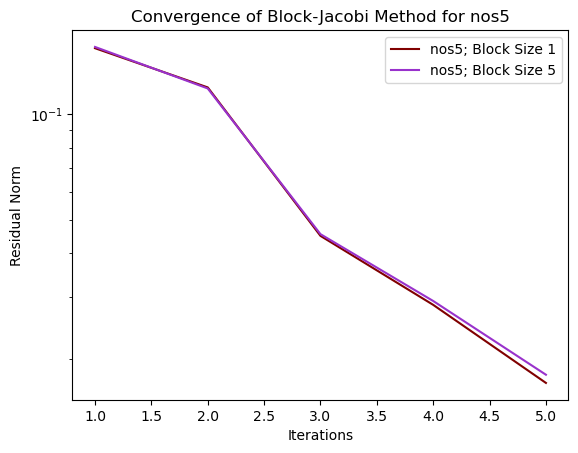

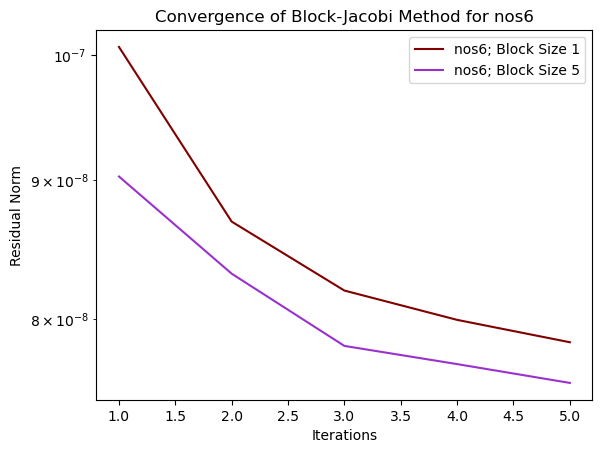

In [9]:
plot_residuals(results, 'nos5')
plot_residuals(results, 'nos6')

Hint: To verify the correctness of your implementation, you can use the small test problem `test_13.mtx` provided on Moodle, which results in the following residual norms for the first 5 iterations (rounded to three decimal digits):
$$block\_size = 1: \quad [0.0754, 0.00885, 0.00249, 0.000258, 4.92\cdot 10^{-5}]$$
$$block\_size = 5: \quad [0.0397, 0.00693, 0.00127, 0.000168, 2.17\cdot 10^{-5}]$$

In [10]:
# testing the implementation on correctives

test_13 = (sp.io.mmread('test_13.mtx')).tocsr()


exact_solution_13 = np.ones(test_13.shape[0])
b_13 = test_13 @ exact_solution_13
genesis_x_13 = np.zeros(test_13.shape[0])

res_vec_13 = []

for cnt, block_size in enumerate([1, 5]):
    d_13, e_13 = split_matrix(test_13.copy(), block_size)
    _, _, res = block_jacobi(d_13, e_13, test_13, b_13, 5, tol, genesis_x_13)
    res_vec_13.append(res)
print(res_vec_13)

[array([7.54462164e-02, 8.84856360e-03, 2.48785904e-03, 2.58311438e-04,
       4.92468057e-05]), array([3.96945743e-02, 6.93400295e-03, 1.26683162e-03, 1.68111681e-04,
       2.17146308e-05])]


## Preconditioned Conjugate Gradient method
Implement the preconditioned conjugate gradient method and experimentally investigate the effect of different preconditioners on its convergence.
Use your `block_jacobi` function as an implicit preconditioner.

Create a function `pcg` of the following form:
$$[x, iterations, res\_vec] = pcg(A, b, maxit, tol, x_0, maxit\_prec, blocksize\_prec)$$

<u>Input</u>:
 - Sparse Matrix $A$ of size $ n \times n  $.
 - Vector $b$ of size $n \times 1 $.
 - Integer $maxit$. <br>
 - Scalar $tol$.
 - Vector $x_0$ of size $n \times 1 $.
 - Integer $maxit\_prec$.
 - Integer $blocksize\_prec$.

<u>Output</u>: 
 - Vector $x$ of size $n \times 1 $.
 - Integer $iterations$.
 - Vector $res\_vec$ of size $iterations \times 1$. <br>
 
Remark: 
- The parameter $tol$  denotes the largest admissible relative residual norm $ r $.  <br>
- The iteration is terminated either when the residual drops below $tol$, or when the number of iterations exceeds a specified amount $maxit$. The initial guess is supplied via the vector $x_0$.  <br>
- The parameter $maxit\_prec$ defines the number of Block Jacobi iterations performed in each iteration as a preconditioner application. If $maxit\_prec=0$, the PCG solver shall NOT use a preconditioner. Make sure that the tolerance of the Block Jacobi method is set sufficiently small (e.g., set it to $0$). The parameter $blocksize\_prec$ defines the block size used to split the input matrix $A$.
- The list of return values contains, apart from the solution vector $x$, the number $ iterations $ of iterations actually performed and the residual history in $res\_vec$, where $res\_vec(i)$ contains the relative residual after iteration $ i - 1 $. Note that the initial residual norm $\|b-Ax_0\|/(\|A\|\|x_0\|)$ is not stored in this array.

Hint: To verify the correctness of your implementation, you can compare it to `scipy.sparse.linalg.cg`. While this step is not mandatory, it can be helpful if you are uncertain.


#### Efficiency

Make sure to exploit the sparsity of the input matrix $A$, i.e., execute a **sparse** matrix-vector product in each iteration.

Moreover, make sure that you do not execute steps in each iteration that can be done once at the beginning of the solver. For example, compute the matrices $D$ and $E$ for the `block_jacobi` preconditioner only once at the beginning of the `pcg` solver.

In [11]:
def pcg(A, b, maxit, tol, x0, maxit_prec, blocksize_prec):
    # TODO: Write your implementation of the function

    if not isinstance(A, sp.sparse.csr_matrix):
        raise TypeError("Matrix A must be a CSR sparse matrix!")
    if not isinstance(b, np.ndarray) or not isinstance(x0, np.ndarray):
        raise TypeError("b and x0 must be numpy arrays!")
    if A.shape[0] != A.shape[1]:
        raise ValueError("A must be square!")
    if A.shape[0] != b.shape[0] or A.shape[0] != x0.shape[0]:
        raise ValueError("Dimensions of A, b, and initial x have to match!")
    if not isinstance(tol, float):
        raise TypeError("tol must be a float!")
    if not isinstance(maxit, int) or not isinstance(maxit_prec, int) or not isinstance(blocksize_prec, int):
        raise TypeError("maxit and precondition metrics have to be integers!")

    A = A.copy()
    
    # initial setup step
    x = x0.copy()
    # initial residual
    r = b - A @ x
    res_0 = np.linalg.norm(r)
    res_vec = []
    
    
    
    # precondition matrix A if wanted to
    if maxit_prec > 0:
        D, E = split_matrix(A, blocksize_prec)
        def precondition(r):
            return block_jacobi(D, E, A, r, maxit_prec, tol, np.zeros_like(r))[0]
    else:
        def precondition(r):
            return r
        
    u = precondition(r)  
    p = u.copy()
    
    reps = 0
    
    for k in range(maxit):
        
        alpha = (r @ u) / (p @ (A @ p))
        x += alpha * p
        neo_r = r - alpha * (A @ p)
        
        res = np.linalg.norm(neo_r)
        rel_res = res / res_0
        res_vec.append(rel_res)
        
        if rel_res < tol:
            reps = k
            break
        
        # new u with potential preconditioning with new cur residual
        neo_u = precondition(neo_r)
        
        beta = (neo_r @ neo_u) / (r @ u)
        
        p = neo_u + beta * p
        
        r = neo_r
        u = neo_u
        reps = k
        
    cg_iterations = reps + 1
    return x, cg_iterations, res_vec

Evaluate the convergence behaviour of PCG for the matrices **NOS5** and **NOS6**.

Determine the corresponding right hand side $b$ such that the exact solution $x$ of the linear system is a vector of all ones: $x = (1, 1, . . . , 1, 1)^T$.
</u>

Use a tolerance $tol$ of $10^{-8}$ for the relative residual as convergence criterion.
</u>

Initialize both `pcg` and `block_jacobi` with zero vectors as initial guesses.

For each matrix, plot the residual histories (i.e., the iterations on the x-axis, the relative residual corresponding to the respective iteration on the y-axis). <u>When plotting residuals, always use a **logarithmic scale** along the **y-axis**!

Generate the following plot for each matrix:

- Relative residual vs. iterations: One figure using PCG (without preconditioning) and PCG with the `block_jacobi` preconditioner with iteration counts 1 and 5 and with block sizes 1 and 5 (i.e., five different executions of the Conjugate Gradient method).

Additionally, measure the runtime of the unpreconditioned method and the method using the different preconditioners for both matrices. Your code should output the resulting runtimes.

Remark: Your preconditioner should execute either 1 or 5 iterations. That does not apply to the PCG solver itself, which should execute the number of iterations necessary to achieve the accuracy $10^{-8}$.

In [12]:
def plot_results(results):

    color_palette = {
        'no-prec': 'magenta',
        'block_size=1_maxit_prec=1': 'maroon',
        'block_size=1_maxit_prec=5': 'darkorchid',
        'block_size=5_maxit_prec=1': 'saddlebrown',
        'block_size=5_maxit_prec=5': 'indigo'
    }
    
    for name in results:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # results without precondition
        iterations, residuals = results[name]['no-prec']
        axes[0].plot(range(1, len(residuals) + 1), residuals, label='No Preconditioning', color=color_palette['no-prec'])
        axes[0].set_xlabel('Iterations')
        axes[0].set_ylabel('Rel Residual Norm')
        axes[0].set_yscale('log')
        axes[0].set_title(f'{name} - without Preconditioning')
        axes[0].legend()

        # preconditional plots
        for exe_type in results[name]:
            if exe_type != 'no-prec':
                iterations, residuals = results[name][exe_type]
                axes[1].plot(range(1, len(residuals) + 1), residuals,color_palette[f'{exe_type}'], label=exe_type)

        axes[1].set_xlabel('Iterations')
        axes[1].set_ylabel('Rel Residual Norm')
        axes[1].set_yscale('log')
        axes[1].set_title(f'{name} - with Preconditioning')
        axes[1].legend()

        plt.tight_layout()
        plt.show()

In [13]:
import time

# TODO: Write your implementation here

exact_solution_cg = [np.ones(matrix.shape[0]) for matrix in matrix_list]
b_list_cg = [matrix @ x for matrix, x in zip(matrix_list, exact_solution)]

genesis_x_list_cg = [np.zeros(matrix.shape[0]) for matrix in matrix_list]
tol = 1e-8
maxit = 1000

# containers for result and runtime
results = {'nos5': {}, 'nos6': {}}
runtimes = {'nos5': {}, 'nos6': {}}

for name, matrix in zip(['nos5', 'nos6'], matrix_list):

    mat_num = 0 if name == 'nos5' else 1
    start_time = time.time()
    _, reps, res = pcg(matrix, b_list_cg[mat_num], maxit, tol, genesis_x_list_cg[mat_num], 0, 0)
    end_time = time.time()
    results[name]['no-prec'] = (reps, res)
    runtimes[name]['no-prec'] = end_time - start_time

    for block_size in [1,5]:
        for maxit_prec in [1, 5]:
            key = f'block_size={block_size}_maxit_prec={maxit_prec}'
            start_time = time.time()
            _, reps, res = pcg(matrix, b_list_cg[mat_num], maxit, tol, genesis_x_list_cg[mat_num], maxit_prec, block_size)
            end_time = time.time()
            results[name][key] = (reps, res)
            runtimes[name][key] = end_time - start_time


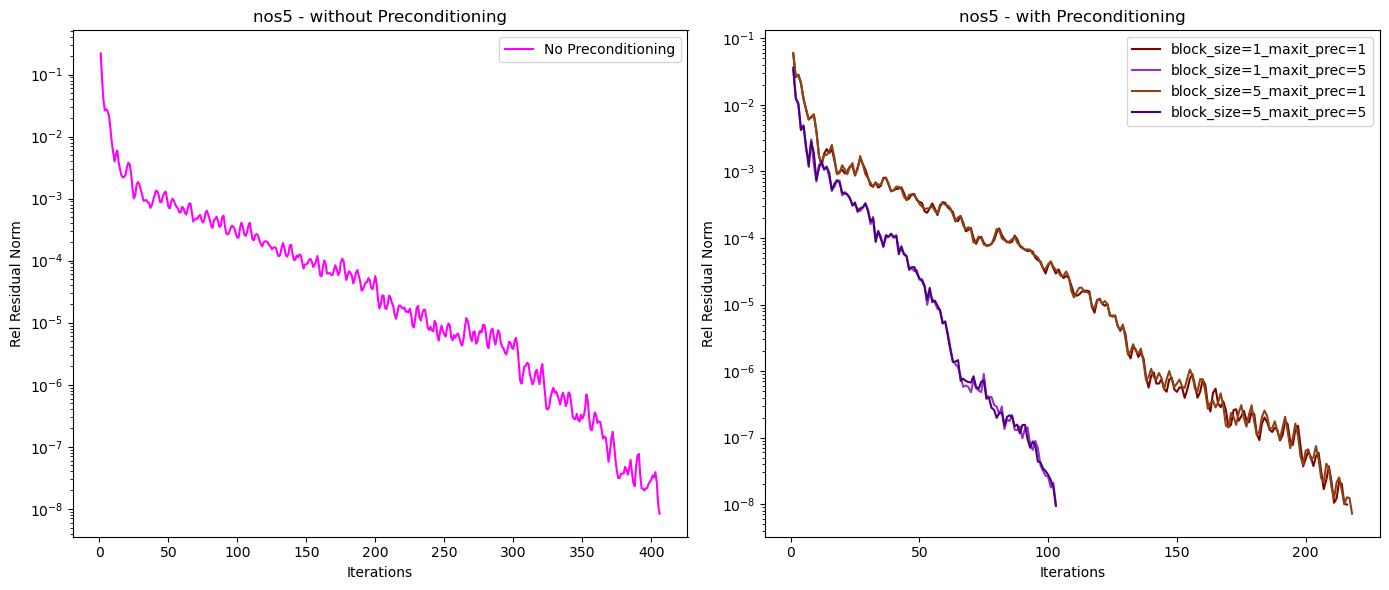

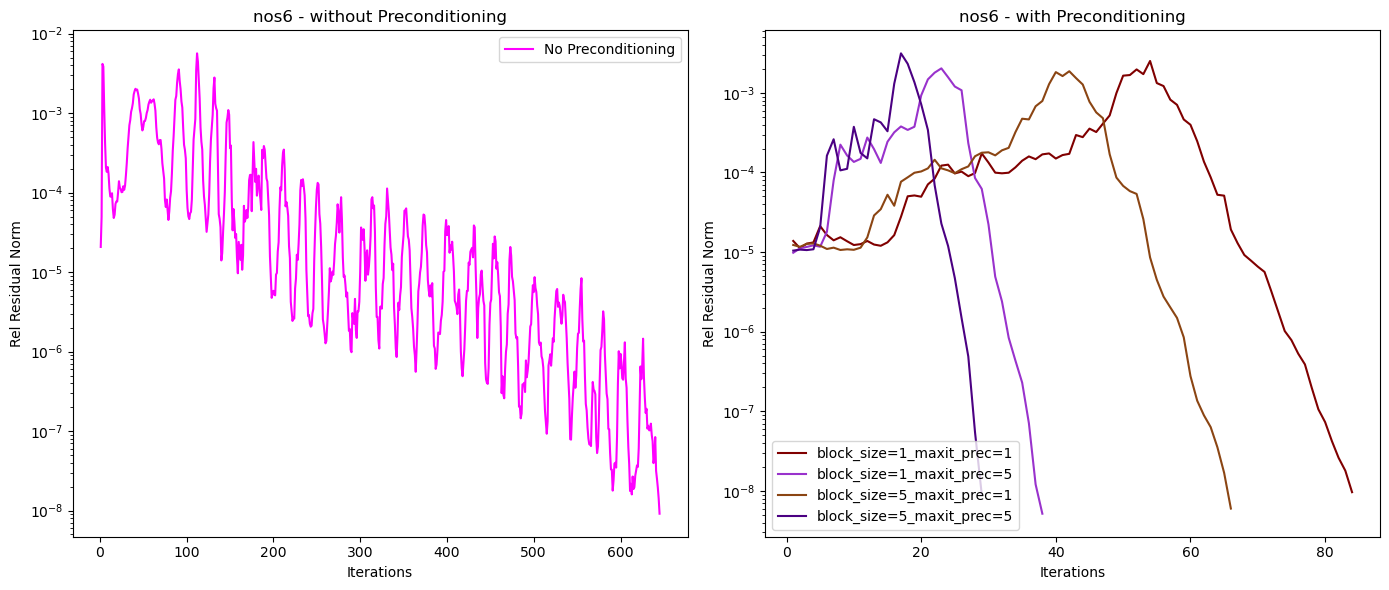

In [14]:
plot_results(results)

In [15]:
def plot_execution_times(times):
    color_palette = {
        'no-prec': 'magenta',
        'block_size=1_maxit_prec=1': 'maroon',
        'block_size=1_maxit_prec=5': 'darkorchid',
        'block_size=5_maxit_prec=1': 'saddlebrown',
        'block_size=5_maxit_prec=5': 'indigo'
    }

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    i = 0
    for name in times:
        labels = list(times[name].keys())
        exec_times = list(times[name].values())
        colors = [color_palette[label] for label in labels]

        axes[i].grid(True, linestyle='dashed')
        axes[i].set_axisbelow(True)
        axes[i].barh(labels, exec_times, color=colors)
        axes[i].set_xlabel('Execution Time (s)')
        axes[i].set_title(f'Execution Times for {name}')
        i += 1
    
    plt.tight_layout()
    plt.show()

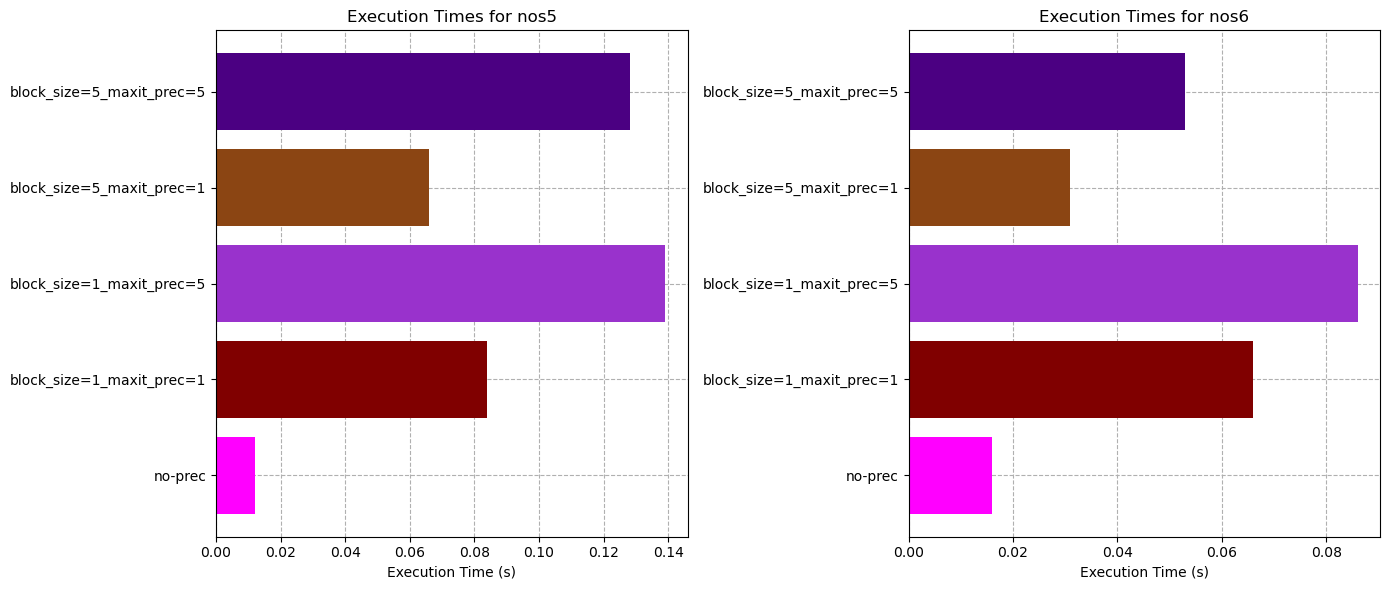

In [16]:
plot_execution_times(runtimes)

In [17]:
import pandas as pd
display(pd.DataFrame(runtimes))

,nos5,nos6
no-prec,0.012,0.016000
block_size=1_maxit_prec=1,0.084,0.066000
block_size=1_maxit_prec=5,0.139,0.086000
block_size=5_maxit_prec=1,0.066,0.031002
block_size=5_maxit_prec=5,0.128,0.052998


In [18]:
[print(matrix.shape) for matrix in matrix_list]

(468, 468)
(675, 675)


[None, None]